In [1]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time

In [2]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

100%|██████████| 150/150 [00:00<00:00, 19139.84it/s]

--- 0.009677886962890625 seconds ---


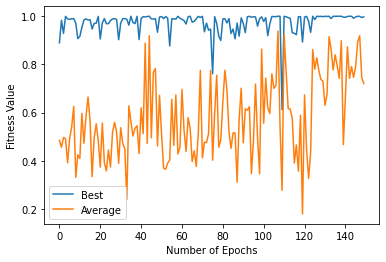

In [112]:
class PSO():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 chrom_length:int,
                 n_best:int,
                 local_factor:float,
                 global_factor:float,
                 speed_factor:float,
                 v_max: float,
                 value_ranges:list,
                 fitness_func, # Function Type,
                 seed=42,
                 eval_every=100,
                 verbose = 0,
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.n_best = n_best
        self.chrom_length = chrom_length
        self.local_factor = local_factor
        self.global_factor = global_factor
        self.speed_factor = speed_factor
        self.v_max = v_max
        self.value_ranges = np.array(value_ranges)
        self.fitness_func = fitness_func
        self.seed = seed    
        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose
        self.f_g_best_alltime = 0

        np.random.seed(seed=seed)

        self.init_pop()
        self.calculate_fitness()
        self.update_gbest()
        self.update_pbest()
        self.update_speed()
        self.update_position()

    def init_pop(self):
        self.x_i = np.random.rand(self.pop_size, self.chrom_length)
        self.v_i = np.random.rand(self.pop_size, self.chrom_length)
        self.v_i = self.v_i * (2 * self.v_max) - self.v_max
        self.f_x_i = self.fitness_func(self.x_i)
        self.f_gbest = self.f_x_i.max()
        self.gbest = self.x_i[self.f_x_i == self.f_x_i.max()].squeeze(axis=0)
        self.pbest = self.x_i.copy()
        self.f_pbest = self.f_x_i.copy()
        # print("### x_i ###")
        # print(self.x_i)
        # print("### f_x_i ###")
        # print(self.f_x_i)
        # print("### gbest ###")
        # print(self.gbest)
        # print("### f_gbest ###")
        # print(self.f_gbest)
    
    def calculate_fitness(self):
        self.f_x_i = self.fitness_func(self.x_i).copy()
        # print("### f_x_i ###")
        # print(self.f_x_i)

    def update_gbest(self):
        curr_max = self.f_x_i.max()
        curr_max = 1
        if curr_max > self.f_gbest:
            mask = self.f_x_i.argmax()
            self.gbest = self.x_i[mask,:]
            self.f_gbest = self.f_x_i[mask]
        return
    
    def update_pbest(self):
        #self.f_pbest = np.array([0,1,0,1,0]).astype(float)
        #self.pbest = np.zeros(shape=self.x_i.shape)
        mask = self.f_x_i > self.f_pbest
        self.pbest[mask,:] = self.x_i[mask,:]
        self.f_pbest[mask] = self.f_x_i[mask]
        return

    def update_pbest_ring(self):
        arr = self.f_x_i
        n = len(arr)
        arr_circular = np.concatenate((arr[n - 1:], arr, arr[:1]))
        #print("##### arr #####")
        #print(self.f_i)

        #print("##### arr_circular #####")
        #print(arr_circular)
        n_matrix = np.vstack((arr_circular[:-2], arr_circular[1:-1], arr_circular[2:])).T
        self.pbest_aux = n_matrix.max(axis=1)
        self.pbest_aux_indices = np.where(self.f_x_i[None,:] == self.pbest_aux[:,None])[1]

        #self.l_best_indices = np.where(self.f_i[:,None] == self.f_l_best[None,:][[0]])[0]
    
        self.l_best = self.x_i[self.pbest_aux_indices]
        mask = self.f_pbest < self.f_x_i

        self.f_pbest[mask] = self.f_x_i[mask]
        self.pbest[mask,:] = self.x_i[mask,:]

    
    def update_speed(self):
        rand_factor_1, random_factor_2 = np.random.rand(2)

        self.v_i = (self.v_i * self.speed_factor) + \
                    (rand_factor_1 * self.global_factor * (self.gbest - self.x_i)) + \
                    (random_factor_2 * self.local_factor * (self.pbest - self.x_i))
        
        self.v_i[self.v_i > self.v_max] = self.v_max
        self.v_i[self.v_i < -self.v_max] = -self.v_max

        # print(self.v_i)
        # print("### gbest ###")
        # print(self.gbest)
        # print("### x_i ###")
        # print(self.x_i)
        # print("### gbest - x_i ###")
        # print(self.gbest - self.x_i)
        # print("### pbest ###")
        # print(self.pbest)
        # print("### pbest - x_i ###")
        # print(self.pbest - self.x_i)
    
    def update_position(self):
        self.x_i = self.x_i + self.v_i
        #print(self.x_i)

    def callback(self):
        max_val = self.f_gbest
        mean_val = np.mean(self.f_x_i)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")

    def fit(self):
        start_time = time.time()
        self.init_pop()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            self.calculate_fitness()
            self.update_gbest()
            self.update_pbest()
            #self.update_pbest_ring()
            self.update_speed()
            self.update_position()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.pbest

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()


    


pso_alg = PSO( 
                num_epochs=150,
                pop_size=20,
                chrom_length=2,
                n_best=2,
                global_factor = 1,
                local_factor = 1,
                speed_factor = 0.8,
                v_max=10,
                value_ranges=[(-10,10), (-10,10)],
                fitness_func=schaffer_function

            )

best_solutions = pso_alg.fit()
pso_alg.plot()

Text(0.5, 0, 'z')

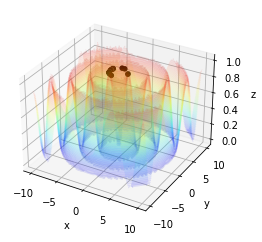

In [113]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g


x_data = best_solutions[:, 0]
y_data = best_solutions[:, 1]
z_data = schaffer_function_plot(x_data, y_data)

x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.1)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)
#ax.set_xlim3d(-10,10)
#ax.set_ylim3d(-10,10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


(-10.0, 10.0)

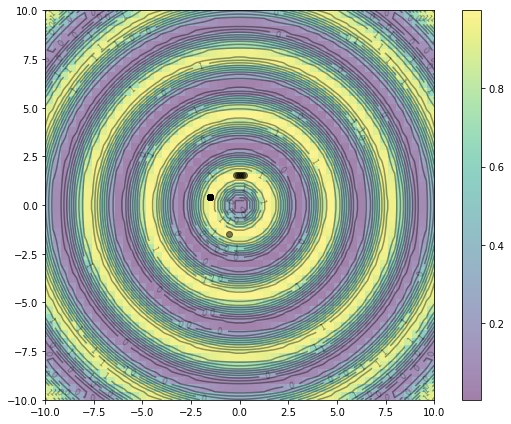

In [100]:
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(Z, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([-10], [10], marker='x', markersize=5, color="white")
contours = ax.contour(X, Y, Z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(best_solutions[:,0], best_solutions[:,1], marker='o', color='black', alpha=0.5)
#p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
#p_arrow = ax.quiver(X[0], X[1], Y[0], Y[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
#gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
